# Predicting Temperature with Least Squares

We'll work with historical temperature data from the Szeged, Hungary, area. The dataset we'll use is a Postgres database version of [this dataset from Kaggle](https://www.kaggle.com/budincsevity/szeged-weather). We will focus on the  following tasks:

- First, load the dataset from the weatherinszeged table from Thinkful's database.
- Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
- Now, check if our model meets the Gauss-Markov conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of our model.


First, we need to import the relevant libraries and do the feature engineering steps. We will later fit the model using Ordinary Least Squares.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

We will also add the following helper function.

In [2]:
def plot_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

### Task 1: Load the dataset from the weatherinszeged table from Thinkful's database.

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

with engine.begin() as conn:
    query = text("""SELECT * FROM weatherinszeged""")
    temperature_df = pd.read_sql_query(query, conn)

# No need for an open connection, because you're only doing a single query
engine.dispose()

temperature_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


We can see that there appears to be no null values and that several variables act as features for predicting temperature.

In [4]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [5]:
temperature_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


### Task 2: Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

First, we confirm that the dataframe is approximately normally distributed.

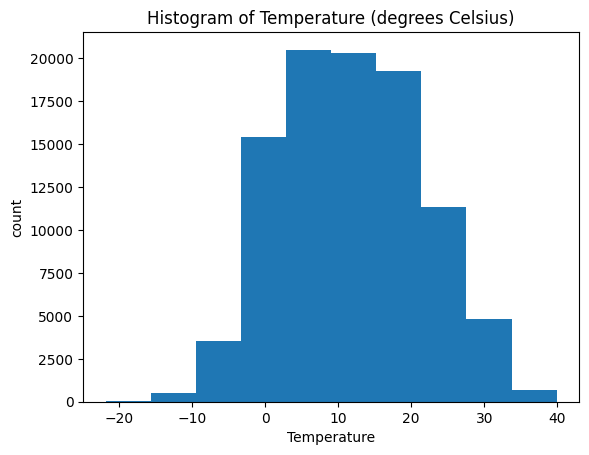

In [6]:
plot_histogram(temperature_df['temperature'],
               xlabel="Temperature",
               title="Histogram of Temperature (degrees Celsius)")

Next, we plot histograms for `humidity`,`windspeed`,`windbearing`, and `pressure`.

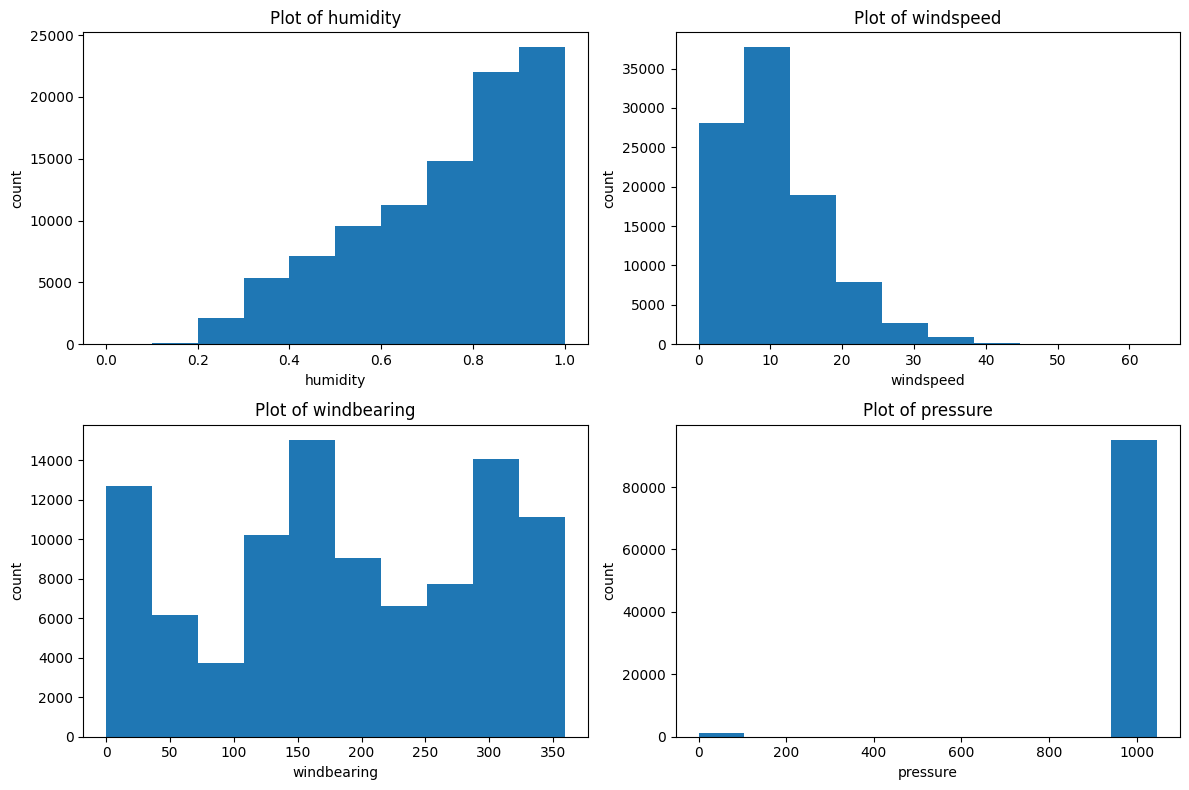

In [7]:
temperature_features = ['humidity','windspeed','windbearing','pressure']
temperature_features_df = temperature_df[temperature_features]

def plot_histogram_with_subplots(series,i,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.subplot(2, 2, i)
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

plt.figure(figsize=(12,8))
for idx, feature in enumerate(temperature_features):
    plot_histogram_with_subplots(temperature_df[feature],
                                 i = idx + 1,
                                 title="Plot of {}".format(feature),
                                 xlabel=feature)
plt.tight_layout()
plt.show()

From these we can see that there are outliers for atmospheric pressure.

In [8]:
# Atmospheric pressure which should be reasonably close to 1000 mbar.
temperature_df.loc[temperature_df['pressure'] < 970,'pressure'].value_counts()

0.000    1288
Name: pressure, dtype: int64

There are 1288 zeroes for atmospheric pressure. Since we are talking about a location in Hungary, it's likely that the zeroes represent missing data. We will remove them.

In [9]:
temperature_df = temperature_df[temperature_df['pressure'] > 0]

Now we will estimate our model using OLS.

In [10]:
# Y is the target variable.
Y = temperature_df['temperature']

# X is the feature set.
X = temperature_df[temperature_features]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

LinearRegression()

In [11]:
lrm.score(X,Y)

0.5286725768206058

In [12]:
# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.27467869e+01 -3.17826353e-01  2.52552064e-03 -4.17393403e-01]

Intercept: 
 463.38270827696556


In [13]:
X.shape

(95165, 4)

In [14]:
Y.shape

(95165,)

### Task 3: Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

### Assumption #1: Linearity of the model in its coefficients

In [15]:
# Predictions of the linear regression
predictions = lrm.predict(X)
predictions

array([ 6.67579577,  7.42365381,  9.45807135, ..., 18.33520125,
       16.38779807, 17.49947671])

In [16]:
predictions.shape

(95165,)

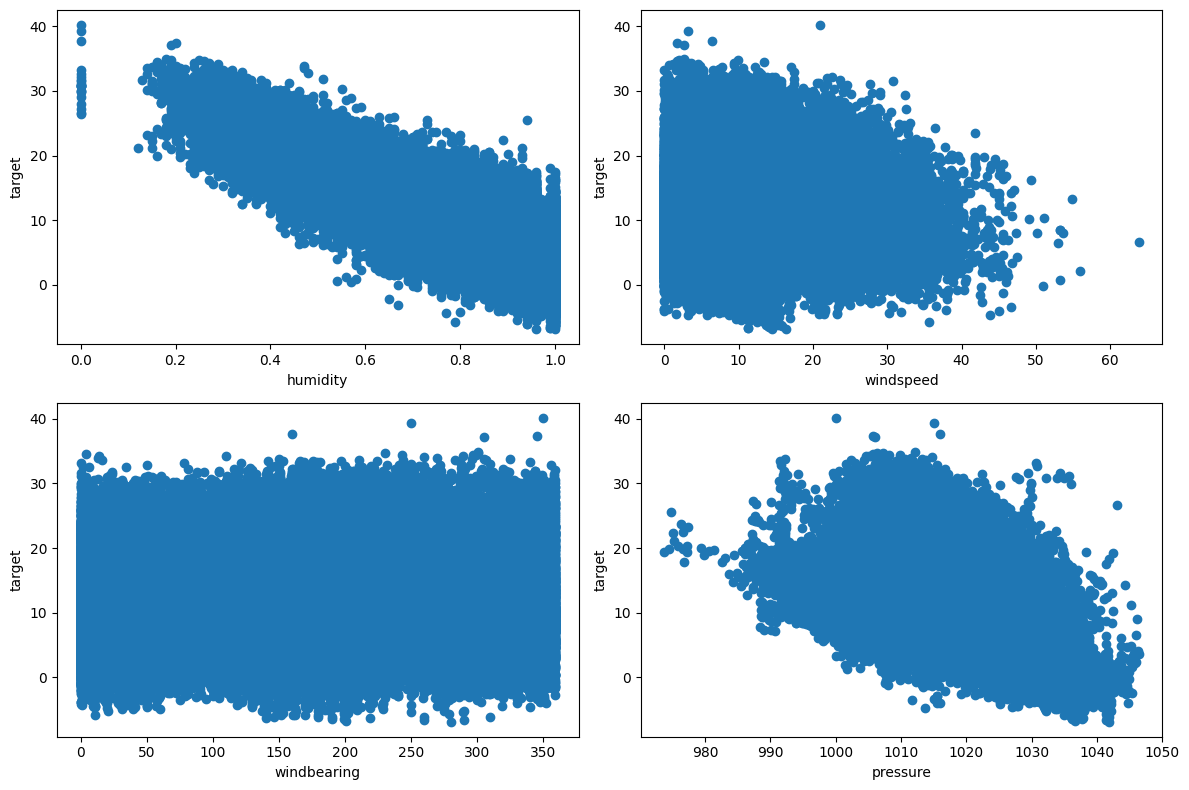

In [17]:
# We plot the estimated Y, and X features
plt.figure(figsize=(12,8))
for i, feature in enumerate(temperature_features):
    plt.subplot(2, 2, i+1)
    plt.scatter(X[feature], predictions)
    plt.xlabel(feature)
    plt.ylabel("target")
    plt.title('')

plt.tight_layout()
plt.show()

I think these are all linear relationshops.

### Assumption #2 (Exogeneity): The error term should be zero on average

We first confirm that the error is zero by taking the mean of our predictions and our target vector.

In [18]:
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: 7.607395393382556e-14


As mentioned earlier in the lesson, this problem can also be resolved by adding a constant and looking at summary statistics.

In [19]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                 2.668e+04
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        03:50:24   Log-Likelihood:            -3.1395e+05
No. Observations:               95165   AIC:                         6.279e+05
Df Residuals:                   95160   BIC:                         6.280e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         463.3827      2.890    160.341      0.000     457.718     469.047
humidity      -32.7468      0.112   -293.654      0.000     -32.965     -32.528
windspeed      -0.3178      0.003    -96.871      0.000      -0.324      -0.311
windbearing     0.0025      0.000     12.679      0.000       0.002       0.003
pressure       -0.4174      0.003   -147.569      0.000      -0.423      -0.412
==============================================================================
Omnibus:                     3441.751   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3960.090
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                       3.436   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


### Assumption #3: Homoscedasticity

We will first plot the residuals against the expected values.

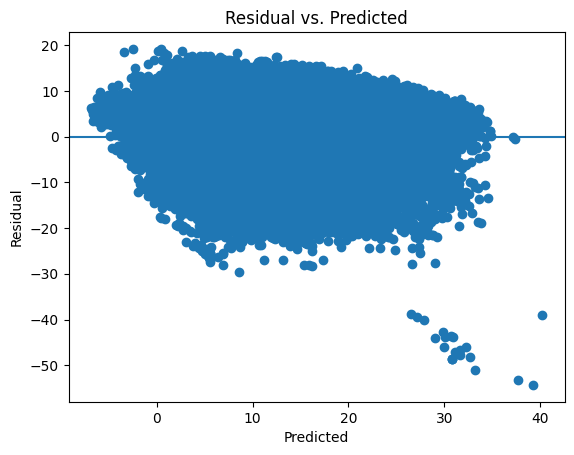

In [20]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This looks like it may not be white noise, so our model may potentially suffer from heteroscedasticity in the error terms. To confirm this, we will review Bartlett and Levene tests from SciPy's stats module. The null hypothesis for both tests is that the errors are homoscedastic.

In [21]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 313.458 and p value is 3.85e-70
Levene test statistic value is 235.663 and p value is 3.74e-53


The p-values of both tests are lower than 0.05. So, our test results reject the null hypothesis and our errors are heteroscedastic.

### Assumption #4: (No perfect) multicollinearity

We can visually check that the independent (feature) variables are not correlated through a heatmap.

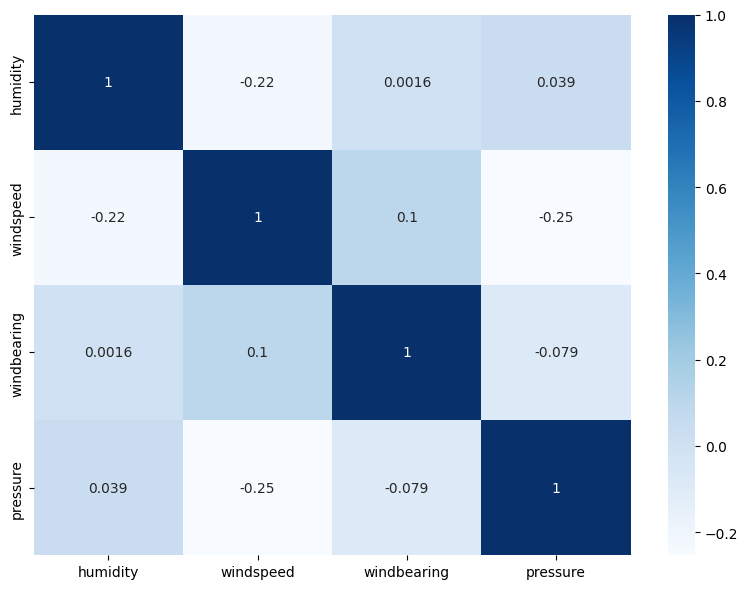

In [22]:
temperature_corr = temperature_df[temperature_features].corr()

# We can check out a heatmap to see the correlations between our variables
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(temperature_corr,cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

This looks good-- our chosen variables seem reasonably independent of each other.

### Assumption #5: Uncorrelated Error Terms

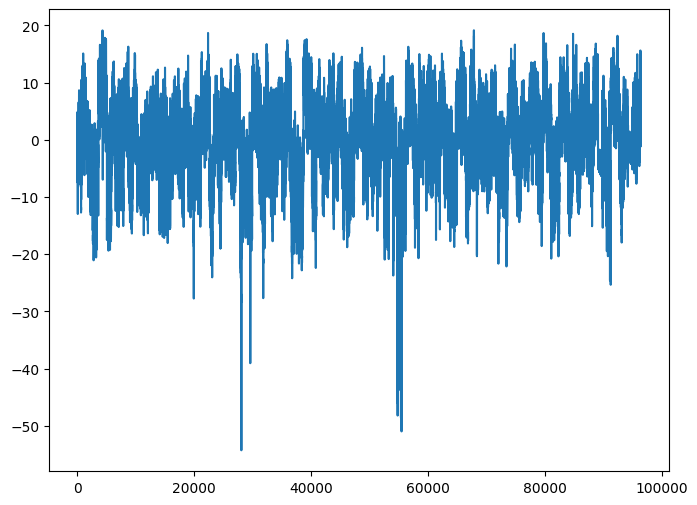

In [23]:
fig=plt.figure(figsize=(8,6))
plt.plot(errors)
plt.show()

It appears that the error terms of our model are uncorrelated with each other. However, we can use the autocorrelation function which computes the correlation of a variable with itself.

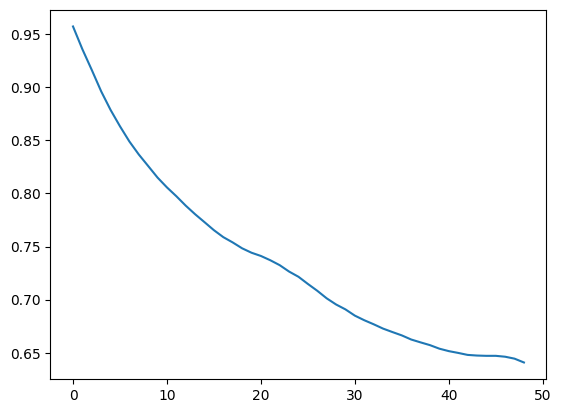

In [24]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The autocorrelation between the errors of our temperature model is fairly high—it ranges between 0.95 and 0.65. The resulting curve almost looks linear.

### Assumption #6: Normality of the errors

There are various ways to check for normality of error terms. We will do this informally by visualizing the errors in a QQ plot or by looking at the histogram, as shown below:

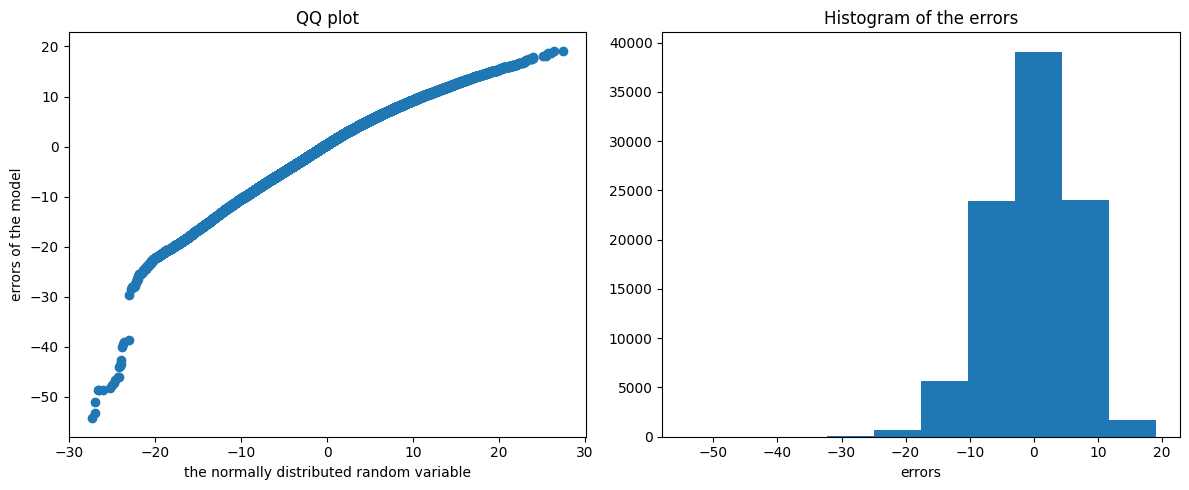

In [25]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors aren't exactly normally distributed. Although, the QQ plot and the histogram imply that the distribution is not very far away from normal.

We can confirm this through two tests from SciPy's stats module: the Jarque-Bera test and the normal test. The null hypothesis of both tests is that the errors are normally distributed.


In [26]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3960.090238932305 and p value is 0.0
Normality test statistics is 3441.751245474635 and p value is 0.0


The p-values of both tests indicate that our errors are not normally distributed.

# Predicting House Prices with Least Squares

Next, we will analyze the house price data including:


- Loading the houseprices data from Thinkful's database.
- Reimplementing the model that you built in the previous lesson.
- Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.

### Task 1: Load the dataset from the house prices table from Thinkful's database.

In [27]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
with engine.begin() as conn:
    query = text("""SELECT * FROM houseprices""")
    house_price_df = pd.read_sql_query(query, conn)

# no need for an open connection, as we're only doing a single query
engine.dispose()

house_price_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


As in the previous lesson, we will first clean the `bsmtqual` column.

In [28]:
bsmtqual_list = house_price_df['bsmtqual']

for i in range(0, len(bsmtqual_list)):
    if pd.isnull(bsmtqual_list[i]):
        bsmtqual_list[i] = 'TA'

bsmtqual_list.unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

### Task 2: Build a regression model where the target variable is sale price. As explanatory variables, use your results from the previous lesson. Estimate the model using OLS.

First, we confirm that the dataframe is approximately normally distributed.

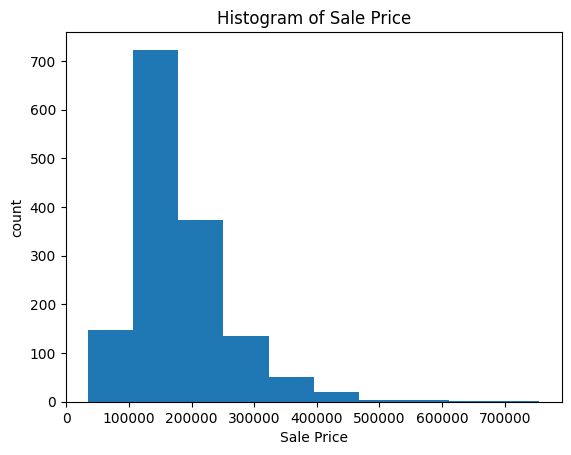

In [29]:
plot_histogram(house_price_df['saleprice'],
               xlabel="Sale Price",
               title="Histogram of Sale Price")

The dataframe is approximately normally distributed. Next, we plot histograms for our numerical features `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`.

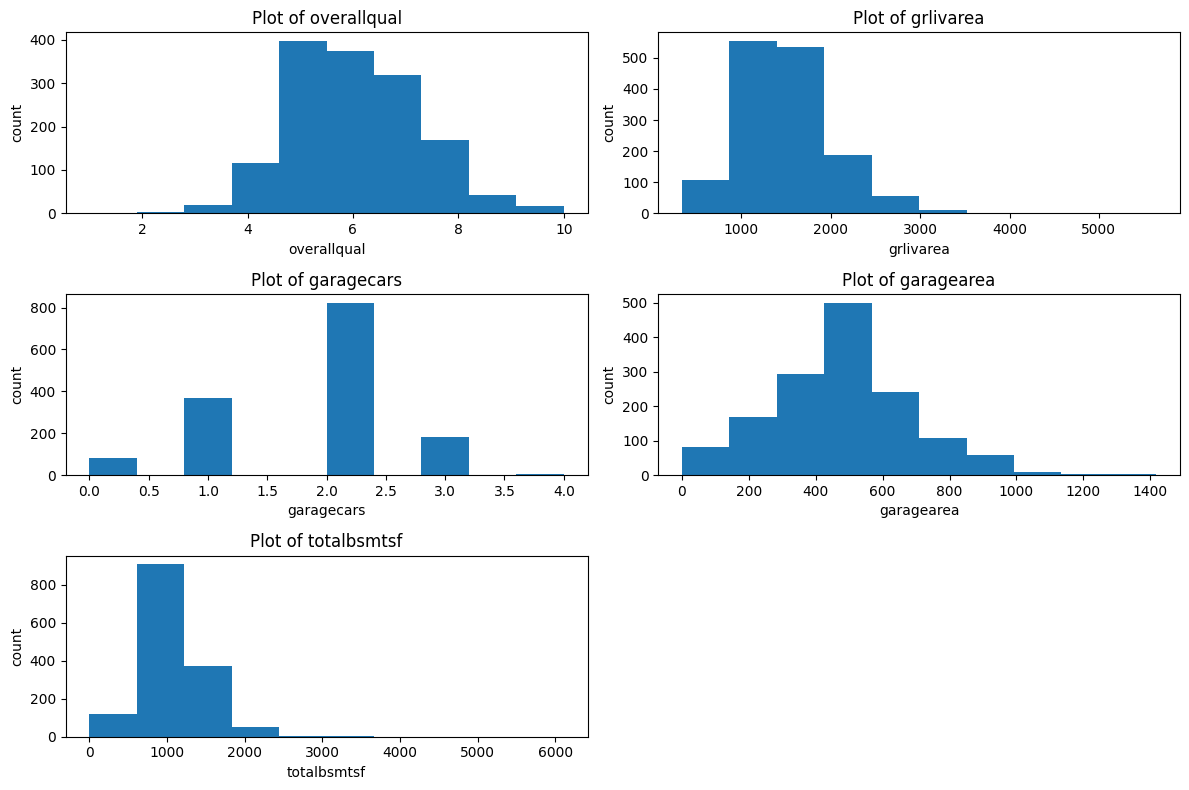

In [30]:
house_price_features = ['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf']
house_price_features_df = house_price_df[house_price_features]

def plot_histogram_with_subplots2(series,i,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.subplot(3, 2, i)
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


plt.figure(figsize=(12,8))
for idx, feature in enumerate(house_price_features):
    plot_histogram_with_subplots2(house_price_features_df[feature],
                                 i = idx + 1,
                                 title="Plot of {}".format(feature),
                                 xlabel=feature)
plt.tight_layout()
plt.show()

These appear to be approximately normally distribiuted.

We previously found that the non-numerical features `mszoning`,`street`,`utilities`,`bsmtqual`, and `salecondition` are important to the sale price. Therefore, we will turn them into dummy variables.

In [31]:
dummy_column_names = []
def convert_to_dummy(df, names, dummy_column_names):
  for name in names:
    df = pd.concat([df,pd.get_dummies(df[name], prefix=name, drop_first=True)], axis=1)
  for name in names:
    dummy_column_names = dummy_column_names + list(pd.get_dummies(df[name], prefix=name, drop_first=True).columns)
  return df, dummy_column_names

house_price_df, dummy_column_names = convert_to_dummy(house_price_df, ['mszoning','street','utilities','bsmtqual','salecondition'], dummy_column_names)

Now let's estimate the model with the non-numerical features above and the numerical variables `overallqual`, `grlivarea`, `garagecars`, `garagearea`, and `totalbsmtsf`.

In [32]:
X = house_price_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_price_df['saleprice']

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

LinearRegression()

In [33]:
lrm.score(X,Y)

0.7987824464930585

In [34]:
# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.78493768e+04  4.75101323e+01  1.12955672e+04  1.06076997e+01
  2.11575542e+01  2.45153746e+04  1.68315500e+04  3.07866556e+04
  1.08595445e+04 -1.09368999e+03 -1.78772376e+04 -6.35714690e+04
 -4.94589729e+04 -5.79808956e+04  5.01544643e+03  7.84992635e+03
 -7.62600053e+03  9.03108026e+03  2.01614803e+04]

Intercept: 
 -32772.92485625675


In [35]:
X.shape

(1460, 19)

In [36]:
Y.shape

(1460,)

### Task 3: Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

### Assumption #1: Linearity of the model in its coefficients

In [37]:
# Predictions of the linear regression
predictions = lrm.predict(X)
predictions

array([209195.13246365, 177717.70575768, 214796.44796831, ...,
       222431.78281576, 125082.29073118, 137687.01611473])

In [38]:
predictions.shape

(1460,)

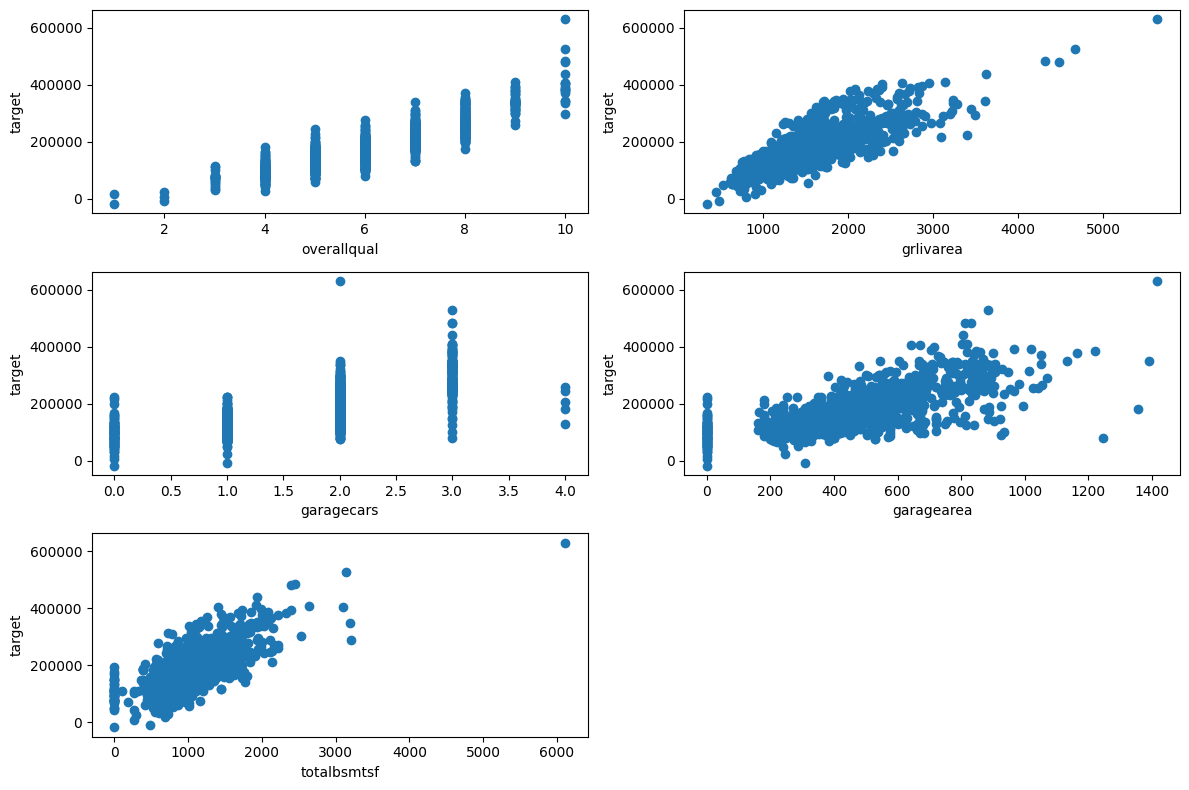

In [39]:
# We plot the estimated Y, and X features

plt.figure(figsize=(12,8))
for i, feature in enumerate(house_price_features):
    plt.subplot(3, 2, i+1)
    plt.scatter(X[feature], predictions)
    plt.xlabel(feature)
    plt.ylabel("target")
    plt.title('')

plt.tight_layout()
plt.show()

Excluding `garagecars` and `overallqual`, the relationship looks linear.

### Assumption #2 (Exogeneity): The error term should be zero on average

We first confirm that the error is zero by taking the mean of our predictions and our target vector.

In [40]:
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: -2.3920956539781125e-12


As mentioned earlier in the lesson, this problem can also be resolved by adding a constant and looking at summary statistics.

In [41]:
# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     300.9
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        03:50:36   Log-Likelihood:                -17374.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1440   BIC:                         3.489e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.277e+04   1.87e+04     -1.756      0.079   -6.94e+04    3841.995
overallqual            1.785e+04   1139.300     15.667      0.000    1.56e+04    2.01e+04
grlivarea                47.5101      2.331     20.384      0.000      42.938      52.082
garagecars              1.13e+04   2888.606      3.910      0.000    5629.241     1.7e+04
garagearea               10.6077      9.898      1.072      0.284      -8.808      30.024
totalbsmtsf              21.1576      2.812      7.523      0.000      15.641      26.674
mszoning_FV            2.452e+04    1.3e+04      1.887      0.059    -971.733       5e+04
mszoning_RH            1.683e+04   1.49e+04      1.130      0.259   -1.24e+04     4.6e+04
mszoning_RL            3.079e+04   1.21e+04      2.551      0.011    7112.717    5.45e+04
mszoning_RM            1.086e+04   1.22e+04      0.888      0.375   -1.31e+04    3.49e+04
street_Pave           -1093.6900   1.53e+04     -0.071      0.943   -3.12e+04     2.9e+04
utilities_NoSeWa      -1.788e+04   3.61e+04     -0.495      0.621   -8.87e+04    5.29e+04
bsmtqual_Fa           -6.357e+04   7835.106     -8.114      0.000   -7.89e+04   -4.82e+04
bsmtqual_Gd           -4.946e+04   4110.818    -12.031      0.000   -5.75e+04   -4.14e+04
bsmtqual_TA           -5.798e+04   4834.945    -11.992      0.000   -6.75e+04   -4.85e+04
salecondition_AdjLand  5015.4464   1.84e+04      0.272      0.786   -3.12e+04    4.12e+04
salecondition_Alloca   7849.9264   1.11e+04      0.705      0.481    -1.4e+04    2.97e+04
salecondition_Family  -7626.0005   8847.348     -0.862      0.389    -2.5e+04    9729.070
salecondition_Normal   9031.0803   3822.143      2.363      0.018    1533.515    1.65e+04
salecondition_Partial  2.016e+04   5246.434      3.843      0.000    9870.008    3.05e+04
==============================================================================
Omnibus:                      597.241   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70631.579
Skew:                          -0.884   Prob(JB):                         0.00
Kurtosis:                      37.029   Cond. No.                     7.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


### Assumption #3: Homoscedasticity

We will first plot the residuals against the expected values.

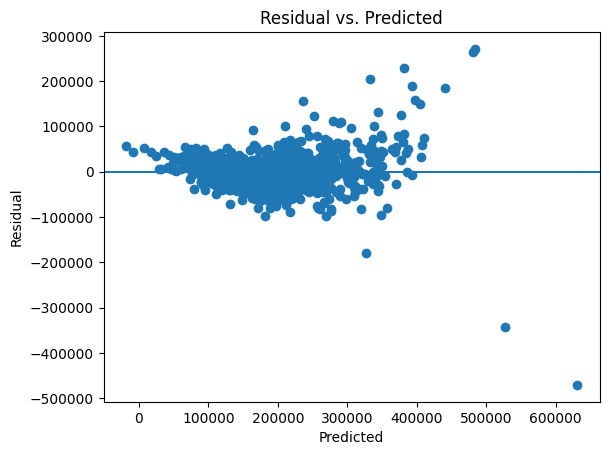

In [42]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This looks like it may not be white noise, so our model may potentially suffer from heteroscedasticity in the error terms. To confirm this, we will review Bartlett and Levene tests from SciPy's stats module. The null hypothesis for both tests is that the errors are homoscedastic.

In [43]:
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 644.279 and p value is 3.92e-142
Levene test statistic value is 516.753 and p value is 1.85e-105


The p-values of both tests are lower than 0.05. So, our test results reject the null hypothesis and our errors are heteroscedastic.

### Assumption #4: (No perfect) multicollinearity

We can visually check that the independent (feature) variables are not correlated through a heatmap.

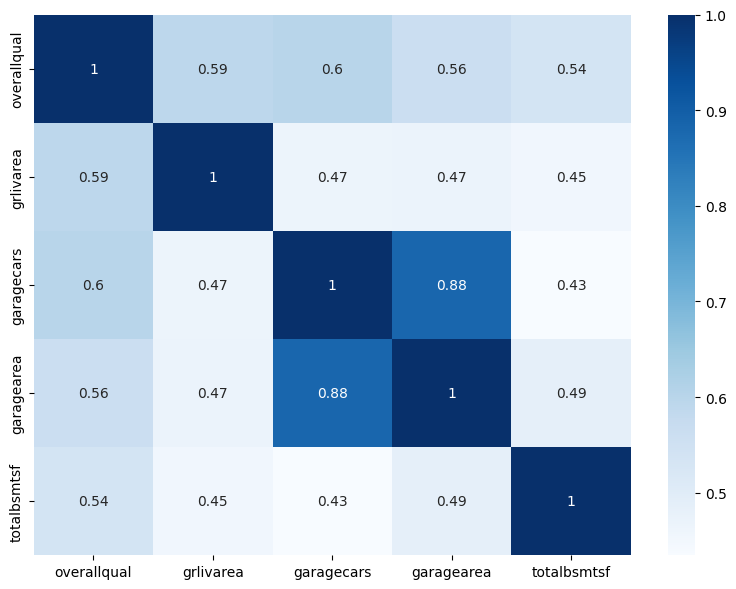

In [44]:
house_price_corr = house_price_df[house_price_features].corr()

# We can check out a heatmap to see the correlations between our variables
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(house_price_corr,cmap='Blues', annot=True, ax=ax)

plt.tight_layout()
plt.show()

This shows us a fundamental flaw in our model assumptions - most of our feature variables have a non-trivial corelation with other feature variables.

### Assumption #5: Uncorrelated Error Terms

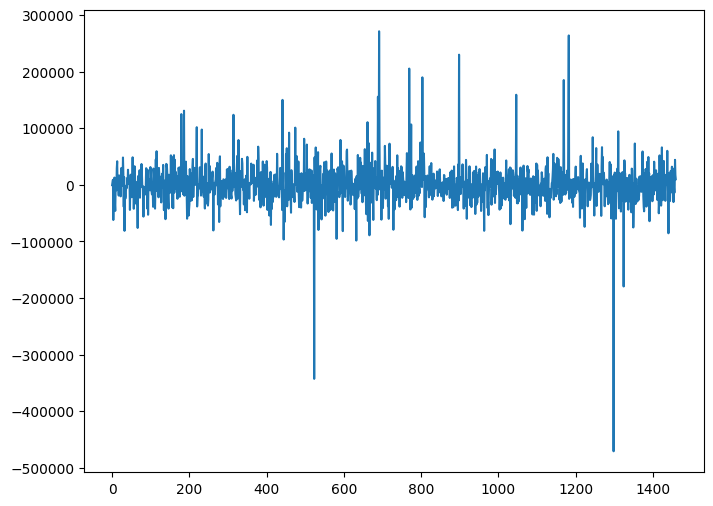

In [45]:
fig=plt.figure(figsize=(8,6))
plt.plot(errors)
plt.show()

It once again appears that the error terms of our model are uncorrelated with each other. Let's use the autocorrelation function which computes the correlation of a variable with itself.

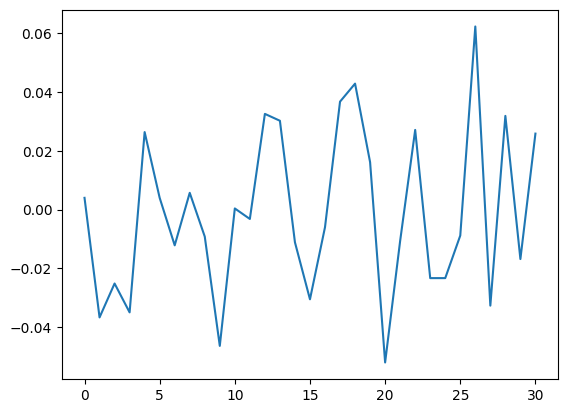

In [46]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The autocorrelation between the errors of our house price model is fairly low and the curve looks like random noise.

### Assumption #6: Normality of the errors

There are various ways to check for normality of error terms. We will do this informally by visualizing the errors in a QQ plot or by looking at the histogram, as shown below:

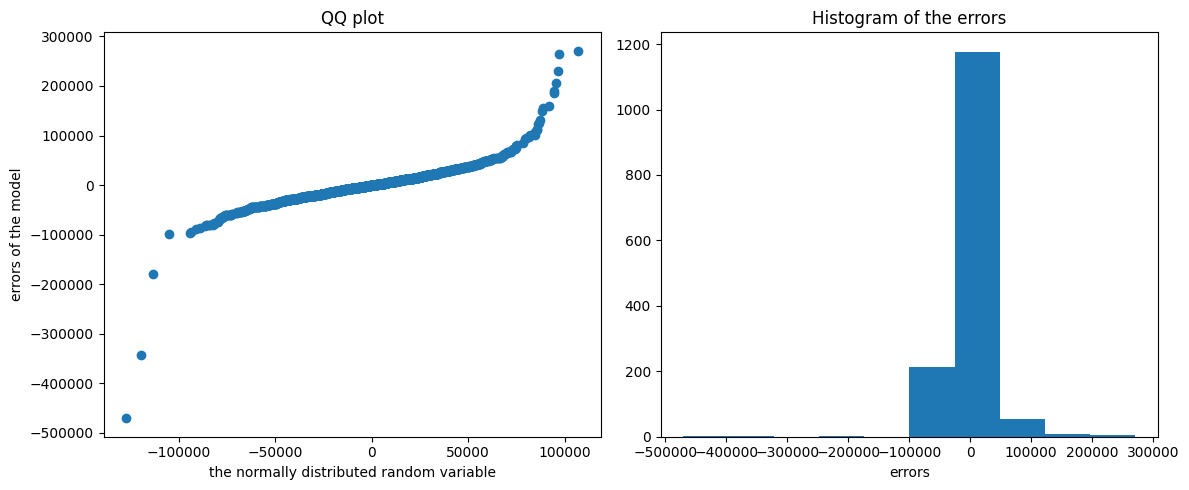

In [47]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

It is difficult to make conclusion based on the charts above. However, it appears that our errors aren't exactly normally distributed. The QQ plot and the histogram imply that the distribution is not very far away from normal.

We can confirm this through two tests from SciPy's stats module: the Jarque-Bera test and the normal test. The null hypothesis of both tests is that the errors are normally distributed.


In [48]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 70631.57939789168 and p value is 0.0
Normality test statistics is 597.2412297028861 and p value is 2.0451011242493466e-130


The p-values of both tests indicate that our errors are not normally distributed.